# House Prices: Advanced Regression Techniques

## Estimating house prices

I applied the XGBoost machine learning technique and to the data. As for feature engineering, I replaced missing data with the most frequent value/category in each column, removed outliers (any prices above 450k) and did one-hot-encoding on the categorical values.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

## Downloading and Preparing the Train data

In [3]:
input_file = "C:/Users/jangn/CODE/Sundog_DataScience/DataScience/DataScience-Python3/data_sets/HousePrices_KaggleCompetition/data/Train_2.csv"

df_train=pd.read_csv(input_file)
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_train.shape # There are 1460 houses with 81 features for each

(1460, 81)

### How much data is missing?
Let's check for any "gaps" in the data.

In [6]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageFinish,81,0.055479
GarageQual,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479


The features **PoolQC, MiscFeature, Alley** and **Fence** are dropped since they are missing between 81 and 99.5% of the data. Trying to replace such a large amount of missing data artificially would probably lead to biases.  <br>
Also the feature 'Id' is dropped, since it carries no value for the training model.

In [7]:
df_train = df_train.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence','Id'], axis=1)

In [8]:
df_train.shape # now the nr of features os down to 76

(1460, 76)

### Spotting and removing outliers
Plotting the 'SalePrice' in a histogram makes it clear that outliers are present!  Looks like any prices above c. 450k could be deleted. 

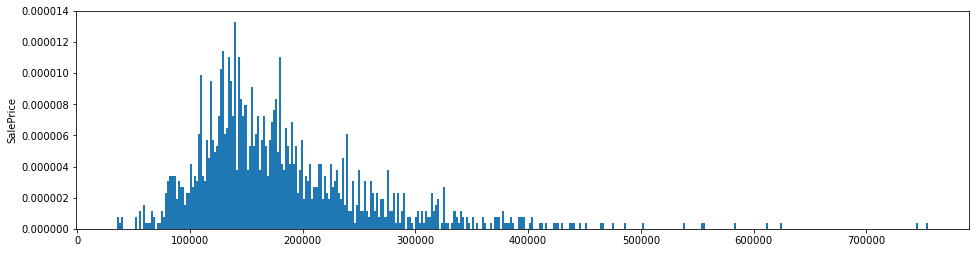

In [9]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] =16.0
fig_size[1] = 4.0

x =df_train['SalePrice']
plt.hist(x, normed=True, bins=400)
plt.ylabel('SalePrice');

We remove the outliers using a function, which leaves out the 'SalePrice' where the value is larger than 450.000.

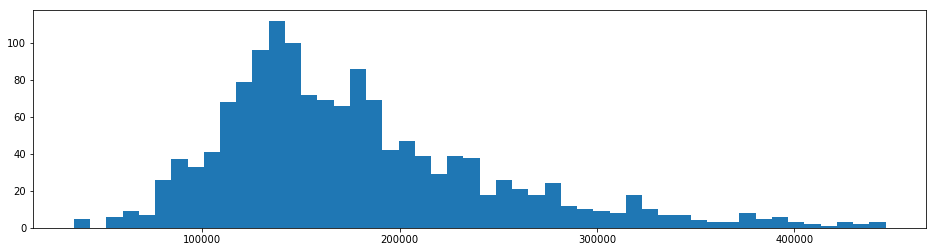

(1446, 1)

In [10]:
def reject_outliers(SalePrice):
    filtered= [e for e in (df_train['SalePrice']) if (e < 450000)]
    return filtered

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] =16.0
fig_size[1] = 4.0

filtered = reject_outliers('SalePrice')
plt.hist(filtered, 50)
fig_size[0]=16.0
fig_size[1]=8.0
plt.show()

df_no_outliers = pd.DataFrame(filtered)
df_no_outliers.shape

This will mean that 14 samples (=1460-1446) will be removed. Let's create  the new dataframe.

In [11]:
df_train = df_train[df_train['SalePrice']<450000]

In [12]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


### Dropping also 'SalePrice' from the df to create X-train

In [13]:
X_train = df_train.drop(['SalePrice'], axis=1)

In [14]:
X_train.shape

(1446, 75)

### Creating the Y-labels, i.e. 'SalePrice'

In [15]:
Y_labels = df_train['SalePrice']

In [16]:
Y_labels.shape

(1446,)

Remaining *categorical* values are found as 'Objects':

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1446 entries, 0 to 1459
Data columns (total 75 columns):
MSSubClass       1446 non-null int64
MSZoning         1446 non-null object
LotFrontage      1188 non-null float64
LotArea          1446 non-null int64
Street           1446 non-null object
LotShape         1446 non-null object
LandContour      1446 non-null object
Utilities        1446 non-null object
LotConfig        1446 non-null object
LandSlope        1446 non-null object
Neighborhood     1446 non-null object
Condition1       1446 non-null object
Condition2       1446 non-null object
BldgType         1446 non-null object
HouseStyle       1446 non-null object
OverallQual      1446 non-null int64
OverallCond      1446 non-null int64
YearBuilt        1446 non-null int64
YearRemodAdd     1446 non-null int64
RoofStyle        1446 non-null object
RoofMatl         1446 non-null object
Exterior1st      1446 non-null object
Exterior2nd      1446 non-null object
MasVnrType       1439 no

In [18]:
# 39 categorical values remain, the rest are numerical. These are the categrocial values:
cat_values= ['FireplaceQu','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType','SaleCondition']

To fill the gaps for these missing CATEGORICAL DATA and NUMERICAL DATA is replaced with their most_frequent value in each category.

In [19]:
X_train = X_train.apply(lambda x:x.fillna(x.value_counts().index[0])) #= fills every numercial column with its own most frequent value

X_train = X_train.fillna(X_train['GarageFinish'].value_counts().index[0]) #fill NaNs with the most frequent value from that column.
X_train = X_train.fillna(X_train['BsmtQual'].value_counts().index[0])
X_train = X_train.fillna(X_train['GarageType'].value_counts().index[0])
X_train = X_train.fillna(X_train['GarageQual'].value_counts().index[0])
X_train = X_train.fillna(X_train['GarageCond'].value_counts().index[0])
X_train = X_train.fillna(X_train['BsmtCond'].value_counts().index[0])
X_train = X_train.fillna(X_train['BsmtExposure'].value_counts().index[0])
X_train = X_train.fillna(X_train['BsmtFinType1'].value_counts().index[0])
X_train = X_train.fillna(X_train['FireplaceQu'].value_counts().index[0])

#### Missing data now replaced by their mean or with categories by the most frequent value in each column. 
### Next, using ScikitLearn's OneHotEncoder to handle text and categorical attributes.

# Enconding Categorical Data


In [20]:
X_train = pd.get_dummies(X_train, columns=['FireplaceQu','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType','SaleCondition'])     

# NO NEED TO CREATE NEW DF, ONE-HOT-COLUMNS AUTOMATICALLY REPLACING CATEGORICAL COLUMNS!!!!

In [21]:
X_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1446.000000,1446.000000,1446.000000,1446.00000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,...,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000
mean,56.995159,67.996542,10426.825726,6.06639,5.577455,1971.030429,1984.684647,98.945367,436.552559,46.627248,...,0.003458,0.080221,0.002075,0.871369,0.069156,0.002766,0.008299,0.013831,0.823651,0.082296
std,42.446131,22.138085,9927.254968,1.34695,1.113250,30.114667,20.654418,171.659401,446.360566,161.520020,...,0.058722,0.271729,0.045517,0.334907,0.253808,0.052541,0.090750,0.116831,0.381248,0.274910
min,20.000000,21.000000,1300.000000,1.00000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,60.000000,7500.000000,5.00000,5.000000,1954.000000,1966.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,50.000000,63.000000,9434.500000,6.00000,5.000000,1972.000000,1993.000000,0.000000,380.500000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,70.000000,78.000000,11494.500000,7.00000,6.000000,2000.000000,2004.000000,160.000000,703.500000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,190.000000,313.000000,215245.000000,10.00000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Over 200 new columns/"features" added through one-hot-encoding!<br>

The following were missing in Test data after the the one-hot-encoding conversion, therefore they will be dropped from Train data in order to keep Train and Test data "equal".

In [22]:
X_train = X_train.drop(['Condition2_RRAe','Exterior2nd_Other','Condition2_RRAn','Condition2_RRNn','HouseStyle_2.5Fin','RoofMatl_ClyTile','RoofMatl_Membran','RoofMatl_Metal','RoofMatl_Roll','Exterior1st_ImStucc','Heating_Floor','Heating_OthW','Electrical_Mix','GarageQual_Ex', 'Exterior1st_Stone','Utilities_NoSeWa'], axis=1)
# 'ElectrecialUnf' was moved...

In [23]:
X_train.shape

(1446, 259)

## Downloading and Preparing the Test data

In [26]:
input_file = "C:/Users/jangn/CODE/Sundog_DataScience/DataScience/DataScience-Python3/data_sets/HousePrices_KaggleCompetition/data/Test_2.csv"

df_test=pd.read_csv(input_file)

In [27]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [28]:
df_test.shape

(1459, 80)

### How much data is missing?
Same check as for the Train data.

In [29]:
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageCond,78,0.053461
GarageQual,78,0.053461
GarageFinish,78,0.053461
GarageType,76,0.052090


Dropping the features PoolQC, MiscFeature, Alley and Fence since they are missing between 80% and 99.5% of the data.

In [30]:
df_test = df_test.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1)

In [31]:
df_test.shape

(1459, 76)

Replace missing CATEGORICAL and NUMERICAL DATA with their most_frequent value in each catgeory.

In [32]:
df_test = df_test.apply(lambda x:x.fillna(x.value_counts().index[0])) #= fills every column with its own most frequent value

df_test = df_test.fillna(df_test['GarageFinish'].value_counts().index[0]) #fill NaNs with the most frequent value from that column.
df_test = df_test.fillna(df_test['BsmtQual'].value_counts().index[0])
df_test = df_test.fillna(df_test['FireplaceQu'].value_counts().index[0])
df_test = df_test.fillna(df_test['GarageType'].value_counts().index[0])
df_test = df_test.fillna(df_test['GarageQual'].value_counts().index[0])
df_test = df_test.fillna(df_test['GarageCond'].value_counts().index[0])
df_test = df_test.fillna(df_test['GarageFinish'].value_counts().index[0])
df_test = df_test.fillna(df_test['BsmtCond'].value_counts().index[0])
df_test = df_test.fillna(df_test['BsmtExposure'].value_counts().index[0])
df_test = df_test.fillna(df_test['BsmtFinType1'].value_counts().index[0])
df_test = df_test.fillna(df_test['BsmtFinType2'].value_counts().index[0])
df_test = df_test.fillna(df_test['BsmtUnfSF'].value_counts().index[0])


Next, enconding Categorical Test Data.

In [33]:
df_test = pd.get_dummies(df_test, columns=['FireplaceQu','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType','SaleCondition'])     


In [34]:
df_test.shape

(1459, 260)

In [35]:
df_test.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,1961,0,468,...,0,0,0,1,0,0,0,0,1,0
1,1462,20,81.0,14267,6,6,1958,1958,108,923,...,0,0,0,1,0,0,0,0,1,0
2,1463,60,74.0,13830,5,5,1997,1998,0,791,...,0,0,0,1,0,0,0,0,1,0
3,1464,60,78.0,9978,6,6,1998,1998,20,602,...,0,0,0,1,0,0,0,0,1,0
4,1465,120,43.0,5005,8,5,1992,1992,0,263,...,0,0,0,1,0,0,0,0,1,0


In [36]:
# Removing the feature 'Id' before implementing the model
X_test = df_test.drop(['Id'], axis=1)

In [37]:
X_test.shape

(1459, 259)

### XGBoost - regressor
I'm using Extreme Gradient Boosting.

In [38]:
from xgboost import XGBRegressor

In [39]:
xgb_clf = XGBRegressor(n_estimators=1000, learning_rate=0.05)

xgb_clf.fit(X_train, Y_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

#### Accuracy after cross validation with X_train
The results from this code was mainly used for guidance while training the model and checking for possible improvements after each feature engineering session. Please note, this code uses cross validation (higher is better), not RMSE (lower is better), as in the actual competition

In [40]:
from sklearn.model_selection import cross_val_score

xgb_clf_cv = cross_val_score(xgb_clf,X_train, Y_labels, cv=10, ) # .911240390855695

print(xgb_clf_cv.mean())  

0.911240390855695


### Making predictions with the model

In [41]:
xgb_clf = XGBRegressor(n_estimators=1000, learning_rate=0.05)

xgb_clf.fit(X_train, Y_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

The resulting array was submitted to https://www.kaggle.com/c/house-prices-advanced-regression-techniques/submit for review; comparing these estimates with the actual prices of the houses in the Test data.

In [42]:
xgb_predictions_test = xgb_clf.predict(X_test) # shape(1459, 262)

xgb_predictions_test 

array([121288.234, 161547.62 , 184054.5  , ..., 153197.94 , 121744.43 ,
       225148.84 ], dtype=float32)

In [43]:
xgb_predictions_test.shape # (1459,)

(1459,)

## Submission file to kaggle.com 

In [44]:
# Create a new dataframe with only the columns Kaggle wants from the data set!
submission = pd.DataFrame({
        "Id": df_test["Id"],
        "SalePrice": xgb_predictions_test
    })

submission.to_csv("kaggleXGB_HousePrices.csv", index=False)
#creates a csv-file that can be uploaded here
# https://www.kaggle.com/c/house-prices-advanced-regression-techniques/submit

### Lessons learned
As mentioned in the Readme-file, this model placed me in around top 40% of all competitors. There would be several possibilities to try to improve the data, e.g. combinining certain features into new ones etc. Anyway, here are listed some of the things I learned whiloe working on the data and the model.
- Make feature engineering to a combined Train and Test set to avoid double-work and to fix possible differences streamlining the data. Afterwards, you simply separate them back into two sets.
- One-hot-encoding is better suited for XGBoost than ordinary Label encoding. Also, One-hot-encoding enhances the FE considerably by adding many new columns. This might become cumbersom with already a large number of original features.
- One-hot-encoding, especially if done separately for Train and Test, leads easily to differences in the additional columns. Thsi will mean you need to work on dropping some new columns from Train/Test to make them aligned.


### Further work?
#### Checking for correlations and feature importances
Some features/variables are more impiortant, and perhaps removing the less significant ones might improve the results?

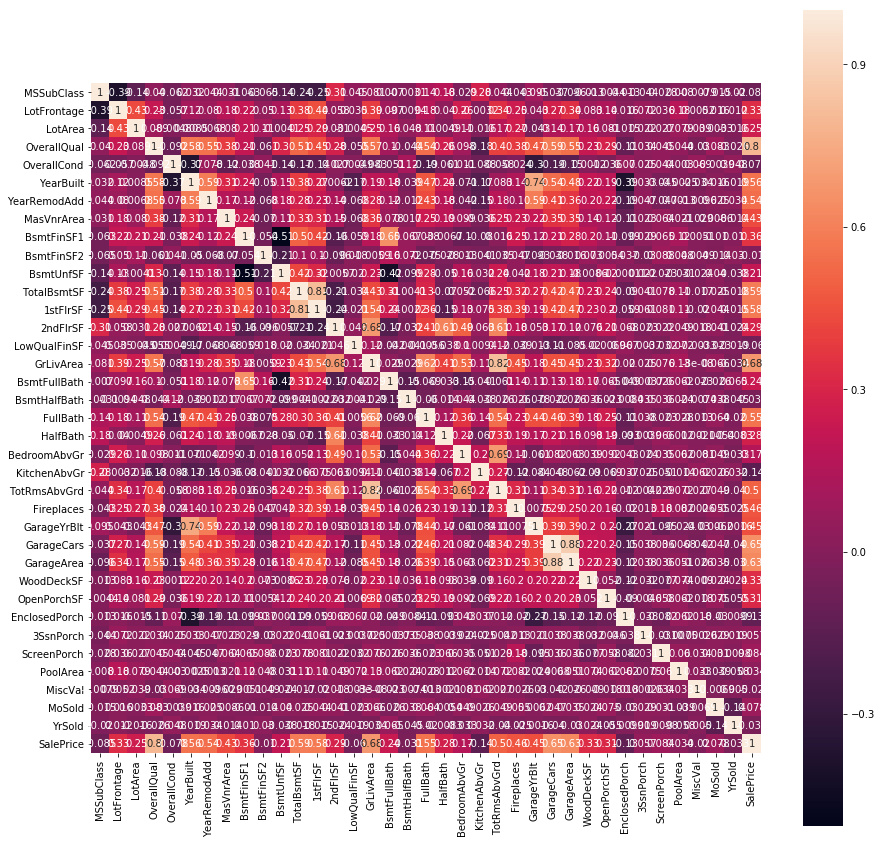

In [45]:
# NOTE!! This one is with df_train, i.e. SalePrice  still included, but before One-Hot-Encoding!!
import seaborn as sns
corr_matrix = df_train.corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, vmax=1, annot=True, square=True);
plt.show()

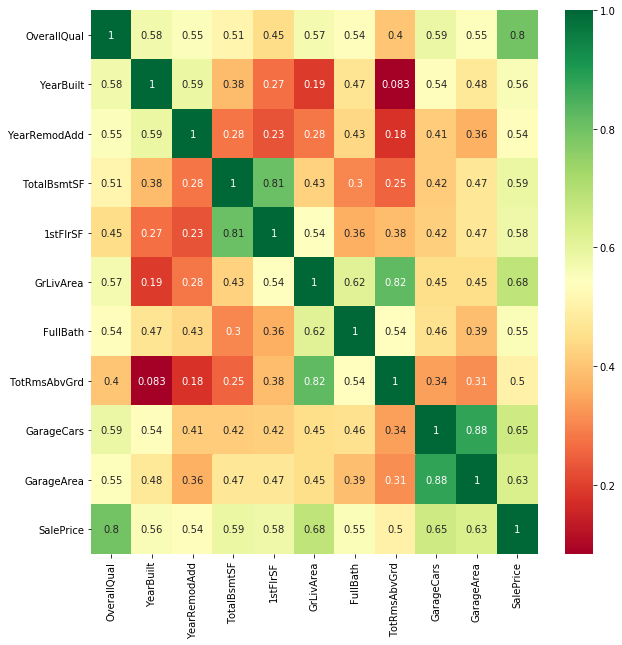

In [46]:
#Most correlated features:
corr_matrix = df_train.corr()
top_corr_features = corr_matrix.index[abs(corr_matrix['SalePrice'])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# NOTE!! This one is with df_train, i.e. SalePrice still included, but before One-Hot-Encoding!!!!

### Checking for feature importance
I can also check for the relative importance of each attribute for making accurate predictions. With this information, I could drop some of the less useful features, should I decide to fine-tune the model further.

[0.01780551 0.05052504 0.07274388 0.04793791 0.02982803 0.01993608
 0.02100137 0.02389286 0.0357632  0.00821793 0.04580734 0.03713286
 0.02845838 0.01719677 0.00258713 0.06102572 0.0094354  0.00243494
 0.00669609 0.00030437 0.00867448 0.00395678 0.00593517 0.00578299
 0.03028458 0.00806574 0.03363263 0.01719677 0.01643585 0.01689241
 0.00928321 0.00928321 0.00776138 0.00015218 0.01856643 0.01171816
 0.00182621 0.00350023 0.00182621 0.00030437 0.00045655 0.00700046
 0.00167402 0.00213057 0.0009131  0.0009131  0.00045655 0.
 0.00136965 0.00060874 0.         0.00273931 0.00167402 0.00152184
 0.00030437 0.00076092 0.         0.00076092 0.00289149 0.00441333
 0.00060874 0.00304368 0.         0.00045655 0.00060874 0.00076092
 0.         0.         0.00350023 0.00213057 0.00121747 0.00593517
 0.00502207 0.00015218 0.00121747 0.00273931 0.00410896 0.00121747
 0.         0.00015218 0.00304368 0.00273931 0.00182621 0.00121747
 0.         0.00030437 0.00486988 0.00700046 0.0009131  0.00197839
 0.

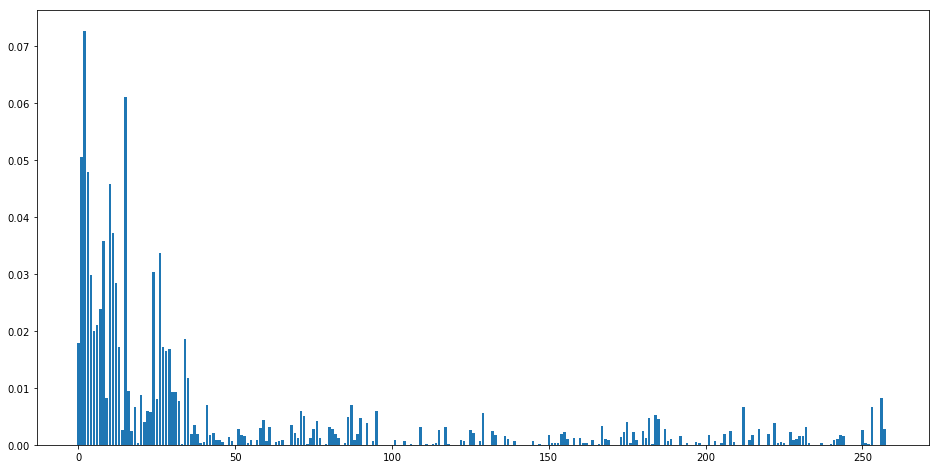

In [47]:
# feature importance
print(xgb_clf.feature_importances_)
from matplotlib import pyplot
# plot
f, ax = plt.subplots(figsize=(16, 8))
pyplot.bar(range(len(xgb_clf.feature_importances_)), xgb_clf.feature_importances_)
pyplot.show()

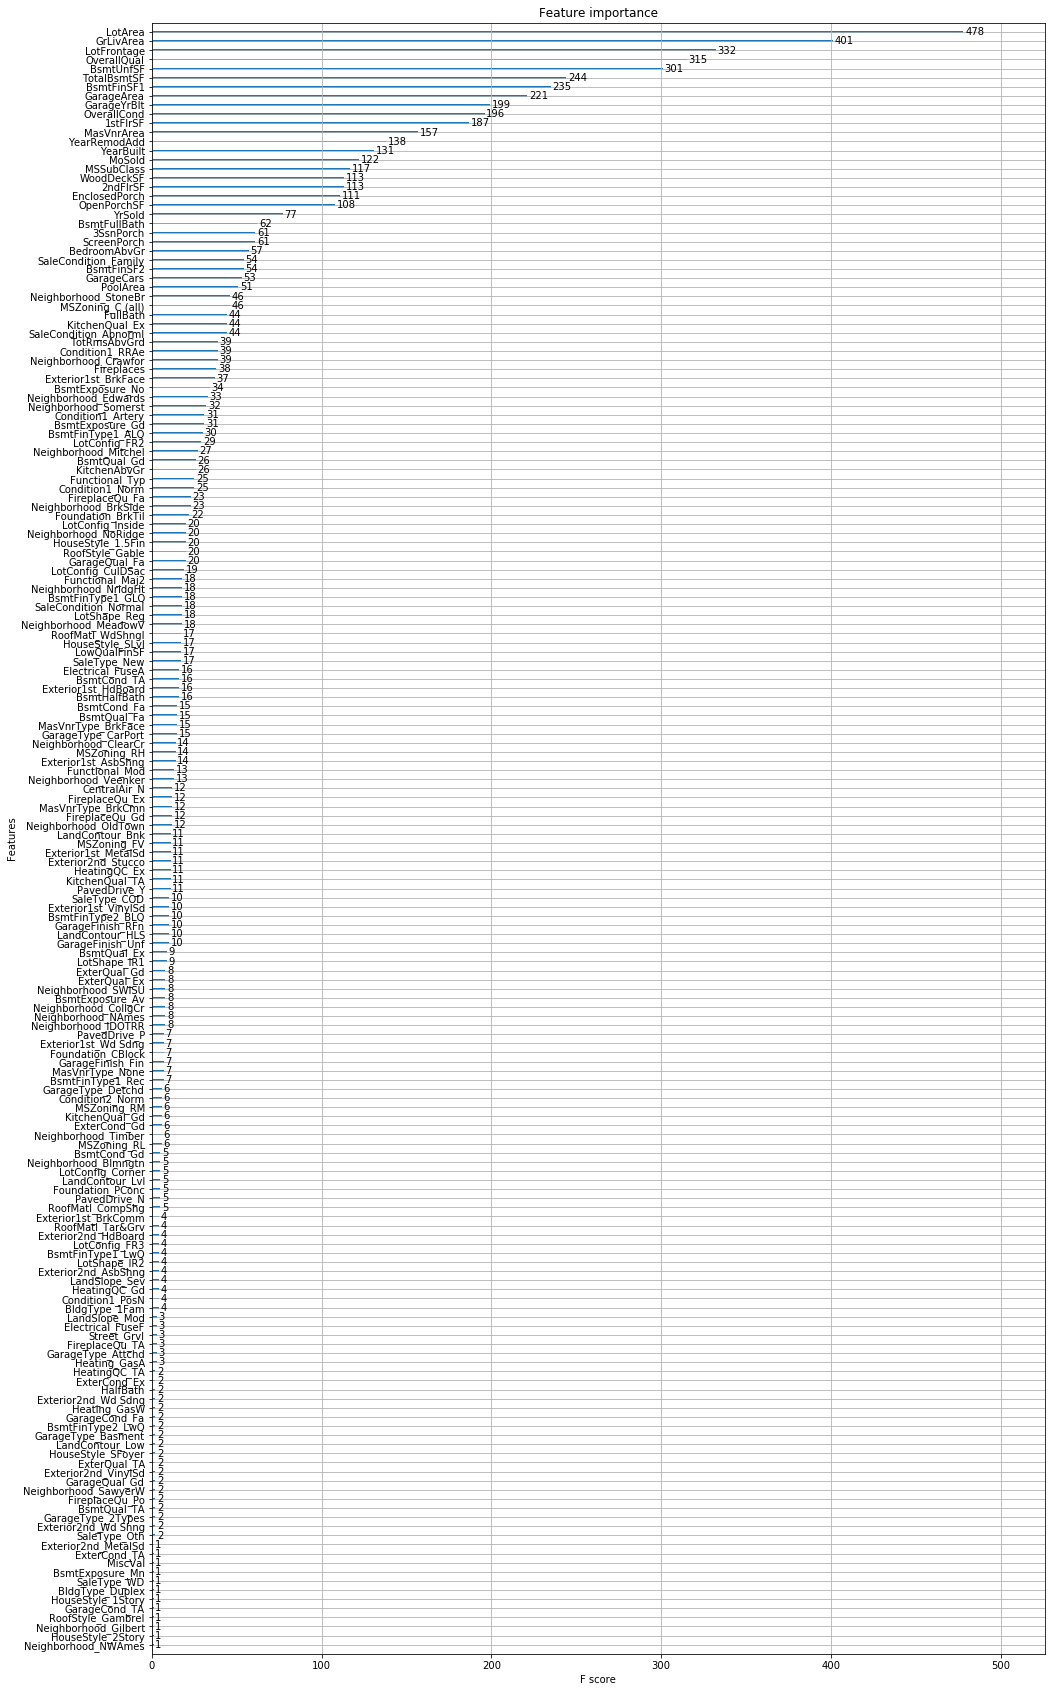

In [48]:
# plot feature importance using a built-in function in XGBoost
from xgboost import plot_importance
fig_size = plt.rcParams["figure.figsize"] 
fig_size[0]=16.0
fig_size[1]=30.0 # from King County House Prices
plot_importance(xgb_clf)
pyplot.show()

### Final words
One could try limiting the number of features to only the ones with an F-score of above 10 or 20, for example